In [35]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
print('imported!')

imported!


In [36]:
train_path = 'cats-and-dogs/train'
validation_path = 'cats-and-dogs/valid'
test_path = 'cats-and-dogs/test'

In [37]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog','cat'], batch_size=10)
validation_batches = ImageDataGenerator().flow_from_directory(validation_path, target_size=(224,224), classes=['dog','cat'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog','cat'], batch_size=10)

Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [38]:
# plots images with labels within Jupter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
        f = plt.figure(figsize=figsize)
        cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
        for i in range(len(ims)):
            sp = f.add_subplot(rows, cols, i+1)
            sp.axis('Off')
            if titles is not None:
                sp.set_title(titles[i],fontsize=16)
            plt.imshow(ims[i], interpolation=None if interp else 'none')

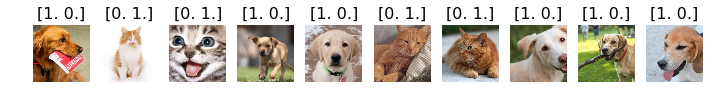

In [39]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

In [40]:
labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Build & train CNN

In [41]:
mobile = keras.applications.mobilenetv2.MobileNetV2()

In [42]:
mobile.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (Activation)         (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [44]:
x = mobile

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation='softmax')
])

In [30]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
model.fit_generator(train_batches, 
                    steps_per_epoch=4,
                    validation_data=validation_batches,
                    validation_steps=2,
                    epochs=5,
                    verbose=2)

Epoch 1/5
 - 2s - loss: 8.0590 - acc: 0.5000 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 2/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 3/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 4/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 5/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 10.0738 - val_acc: 0.3750


# Predict

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1577088)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3154178   
Total params: 3,155,074
Trainable params: 3,155,074
Non-trainable params: 0
_________________________________________________________________


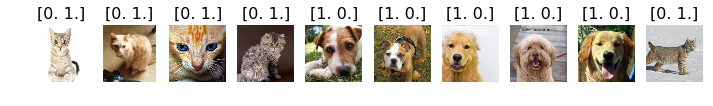

In [9]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles = test_labels)

In [10]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)

In [11]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0).round()

In [12]:
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [13]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0]
 [5 0]]


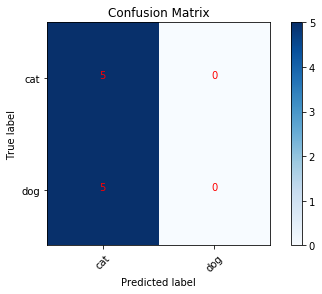

In [15]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# import VGG16 Model

In [45]:
vgg16_model = keras.applications.vgg16.VGG16()

In [46]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [47]:
len(vgg16_model.layers)

23

In [48]:
model = Sequential()
for i in range(22):
    model.add(vgg16_model.layers[i])

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

#model.layers.pop()
t = model.layers.pop()
model.layers[-1].outbound_nodes = []
model.outputs = [model.layers[-1]]#.get_ouput_at(5)]
print(t)
print(model)

In [50]:
for layer in model.layers:
    layer.trainable = False

In [51]:
model.add(Dense(2, activation='softmax'))

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

# Fine-tuning the VGG16 model

In [53]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model.fit_generator(train_batches,
                    steps_per_epoch=4,
                   validation_data=validation_batches,
                   validation_steps=4,
                   epochs=10,
                   verbose=2)

Epoch 1/10
 - 31s - loss: 1.1254 - acc: 0.4750 - val_loss: 0.4908 - val_acc: 0.7500
Epoch 2/10
 - 28s - loss: 0.7899 - acc: 0.6000 - val_loss: 0.3190 - val_acc: 0.9375
Epoch 3/10
 - 28s - loss: 0.5276 - acc: 0.7750 - val_loss: 0.2193 - val_acc: 0.9375
Epoch 4/10
 - 28s - loss: 0.3882 - acc: 0.8750 - val_loss: 0.1573 - val_acc: 0.9375
Epoch 5/10
 - 28s - loss: 0.2713 - acc: 0.9000 - val_loss: 0.1201 - val_acc: 0.9375
Epoch 6/10
 - 27s - loss: 0.2073 - acc: 0.9250 - val_loss: 0.0971 - val_acc: 1.0000
Epoch 7/10
 - 28s - loss: 0.1584 - acc: 0.9750 - val_loss: 0.0825 - val_acc: 1.0000
Epoch 8/10
 - 27s - loss: 0.1068 - acc: 0.9750 - val_loss: 0.0739 - val_acc: 1.0000
Epoch 9/10
 - 27s - loss: 0.0816 - acc: 0.9750 - val_loss: 0.0683 - val_acc: 1.0000
Epoch 10/10
 - 27s - loss: 0.0662 - acc: 0.9750 - val_loss: 0.0643 - val_acc: 1.0000


# Predict using fine-tuned VGG16 model

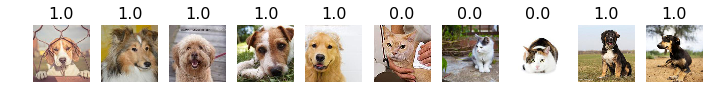

In [56]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=np.round((test_labels[:,0])))

In [57]:
from keras.models import load_model
model =load_model('/Users/zhong/Documents/Jupyter/Personal Coding/flask_apps/VGG16_cats_and_dogs.h5')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [58]:
vgg16_predictions = model.predict_generator(test_batches, steps=1, verbose=2)

In [79]:
test_labels_ = test_labels[:,0]
test_labels_
print('Predic: ' + str(np.round(vgg16_predictions[:,0],decimals=0)))
print('Actual: ' + str(test_labels_))

Predic: [1. 0. 1. 1. 1. 0. 0. 0. 1. 1.]
Actual: [1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]


In [82]:
cm = confusion_matrix(test_labels_, np.round(vgg16_predictions[:,0]))
cm

array([[3, 0],
       [1, 6]])

Confusion matrix, without normalization
[[3 0]
 [1 6]]


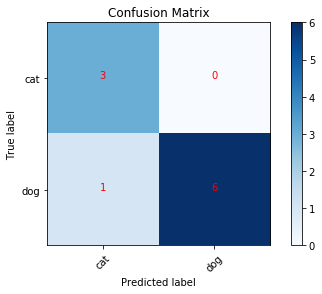

In [83]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [305]:
model.save('/Users/zhong/Documents/Jupyter/Personal Coding/flask_apps/crappy_5_VGG16.h5')

# Image augmentation

In [195]:
from scipy import misc, ndimage

gen = ImageDataGenerator(rotation_range=10,
                         width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.15,
                         zoom_range=0.1,
                        channel_shift_range=10.,
                        horizontal_flip=True)

In [196]:
image_path = 'cats-and-dogs/train/dog/TrainD1.jpg'

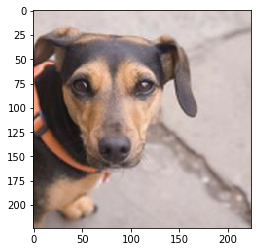

In [198]:
# obtain image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [219]:
# Generate batches of augmented images from this image
aug_iter = gen.flow(image)

In [220]:
# Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]


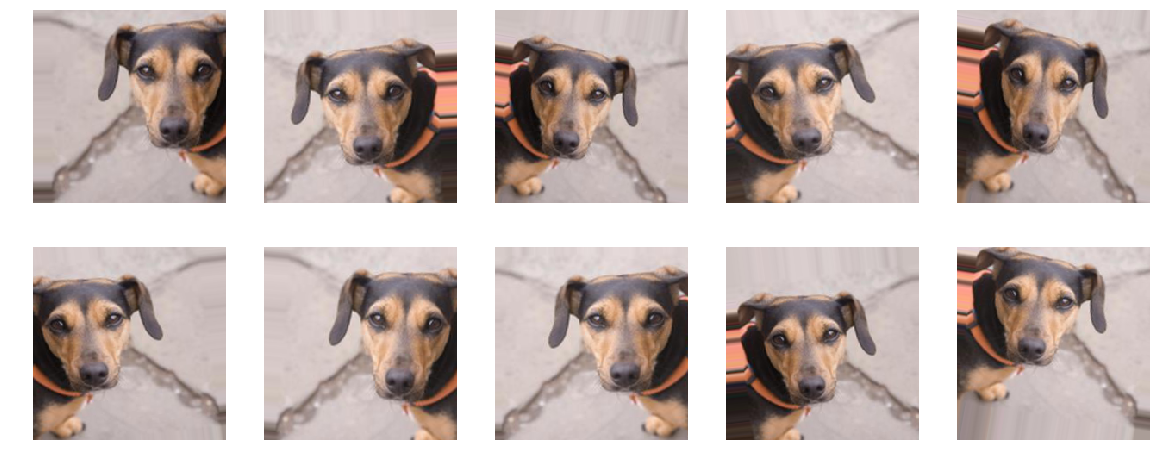

In [221]:
# Augmented images
plots(aug_images, figsize=(20,8), rows=2)

# Reproducible Results

In [222]:
import tensorflow as tf
import random as rn

In [223]:
import os
os.environ['PYTHONASHSEED'] = '0'

In [225]:
# Setting the seed for numpy-generated random numbers
np.random.seed(37)
# Setting the seed for Python random numbers
rn.seed(38)
# Setting the seed for Tensorflow random numbers
tf.set_random_seed(39)

In [229]:
# Force TensorFlow to use a single thread
sess = tf.Session(graph=tf.get_default_graph())#, config=session_conf)
K.set_session(sess)

# Remaining Keras code goes here after

# Learnable parameters in Keras model

In [259]:
#from keras.layers import Dense as LDense
model = Sequential([
    Dense(3, input_shape=(2,), activation = 'relu'),
    Dense(2, activation = 'softmax')
])

In [260]:
model.get_weights()

[array([[ 0.5936725 , -0.9322169 ,  0.60790086],
        [ 0.84957576, -0.01984251, -0.57003474]], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([[-0.30752486, -0.80614614],
        [ 1.0558412 , -0.16111434],
        [ 0.47593486, -0.445875  ]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [236]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 8         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


# Learnable parameters in CNN

In [257]:
from keras.layers.pooling import *
CNNmodel = Sequential([
    Conv2D(2, kernel_size=(3,3), input_shape=[20,20,3], activation='relu', padding='same'),
    Conv2D(3, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(2, activation='softmax'),
])

In [258]:
CNNmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 20, 20, 2)         56        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 20, 20, 3)         57        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 3)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 300)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 602       
Total params: 715
Trainable params: 715
Non-trainable params: 0
_________________________________________________________________
